Exercitiul 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal

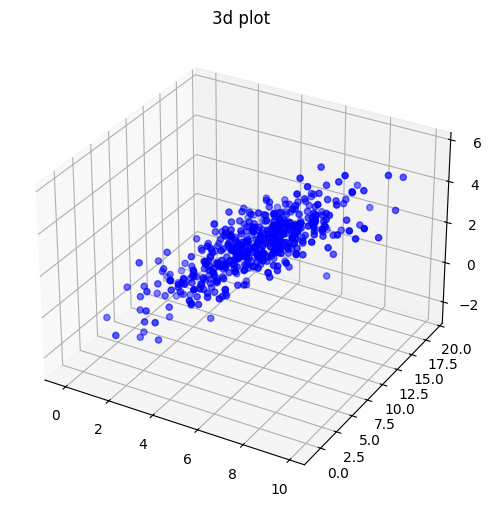

In [9]:
dataset = multivariate_normal([5,10,2], [[3,2,2],[2,10,1],[2,1,2]], 500)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(dataset[:, 0], dataset[:, 1], dataset[:, 2], c='blue')

plt.title('3d plot')
plt.show()


In [10]:
dataset_centered = dataset - np.mean(dataset, axis=0)

cov_matrix = np.cov(dataset_centered, rowvar=False)

eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues_sorted = eigenvalues[sorted_indices]
eigenvectors_sorted = eigenvectors[:, sorted_indices]

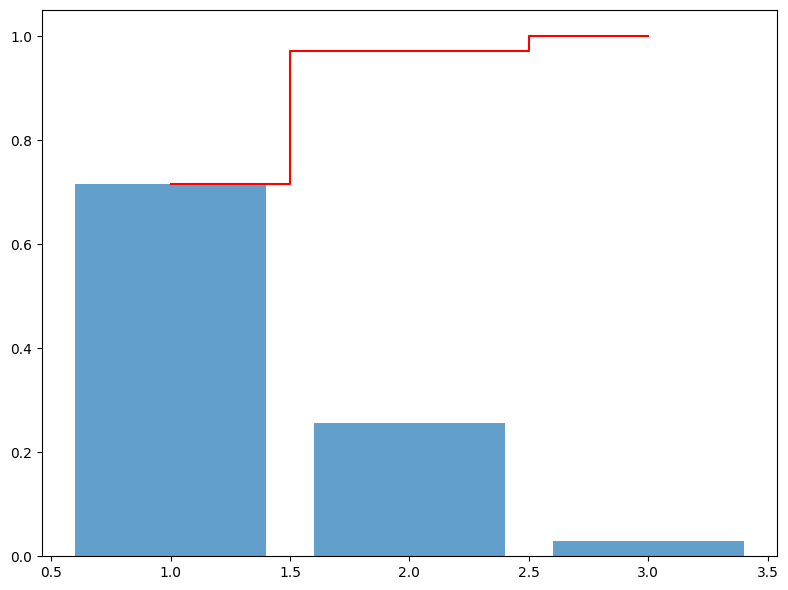

In [11]:
individual_variances = eigenvalues_sorted / np.sum(eigenvalues_sorted)
cumulative_variance = np.cumsum(individual_variances)

plt.figure(figsize=(8, 6))

plt.bar(range(1, len(individual_variances) + 1), individual_variances, alpha=0.7)
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', color='red')

plt.tight_layout()
plt.show()

In [12]:
#project data
principal_components = np.dot(dataset_centered, eigenvectors_sorted)

In [13]:
third_pc = principal_components[:, 2]  

threshold = np.quantile(np.abs(third_pc), 1 - 0.1)

outliers = np.abs(third_pc) > threshold
labels = np.where(outliers, -1, 1)  

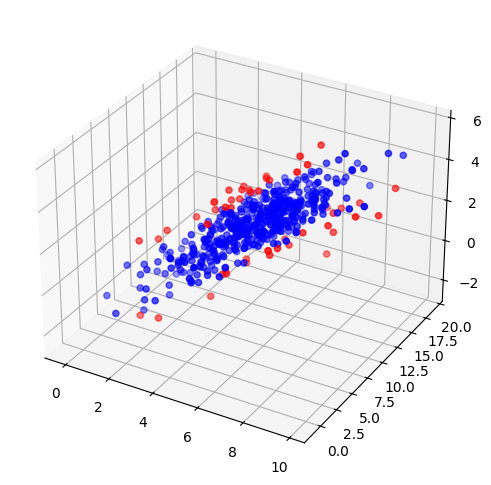

In [14]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

colors = np.where(labels == 1, 'blue', 'red')
ax.scatter(dataset[:, 0], dataset[:, 1], dataset[:, 2], c=colors)

plt.show()


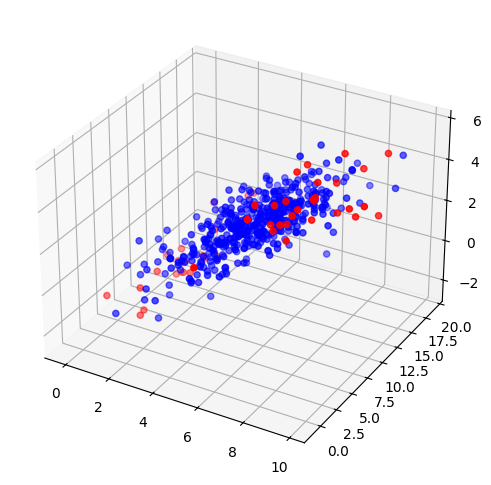

In [15]:
second_pc = principal_components[:, 1]  

threshold1 = np.quantile(np.abs(second_pc), 1 - 0.1)

outliers1 = np.abs(second_pc) > threshold1
labels1 = np.where(outliers1, -1, 1)  
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

colors1 = np.where(labels1 == 1, 'blue', 'red')
ax.scatter(dataset[:, 0], dataset[:, 1], dataset[:, 2], c=colors1)

plt.show()

In [16]:
normalized_data = principal_components / np.sqrt(eigenvalues_sorted)

anomaly_scores = np.sum(normalized_data ** 2, axis=1)
threshold2 = np.quantile(anomaly_scores, 1 - 0.1)
outliers2 = np.where(anomaly_scores > threshold2)[0]

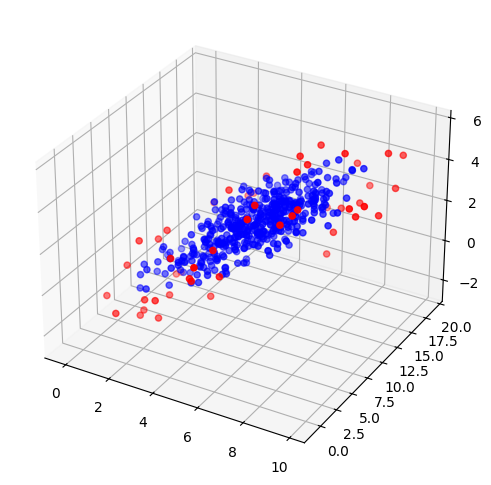

In [20]:
colors2 = np.where(anomaly_scores > threshold2, 'red', 'blue')
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataset[:, 0], dataset[:, 1], dataset[:, 2], c=colors2)
plt.show()

Exercitiul 2

In [2]:
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from pyod.models.pca import PCA
from pyod.models.kpca import KPCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score

In [5]:
data = loadmat('shuttle.mat')
X = data['X']
y = data['y'].ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
contamination_rate = np.sum(y_train) / len(y_train)
print(contamination_rate)

0.07332722273143905


In [7]:
pca_model = PCA(contamination=contamination_rate, random_state=42)
pca_model.fit(X_train)

PCA(contamination=np.float64(0.07332722273143905), copy=True,
  iterated_power='auto', n_components=None, n_selected_components=None,
  random_state=42, standardization=True, svd_solver='auto', tol=0.0,
  weighted=True, whiten=False)

In [8]:
explained_variance = pca_model.explained_variance_
cum_variance = np.cumsum(explained_variance) / np.sum(explained_variance)

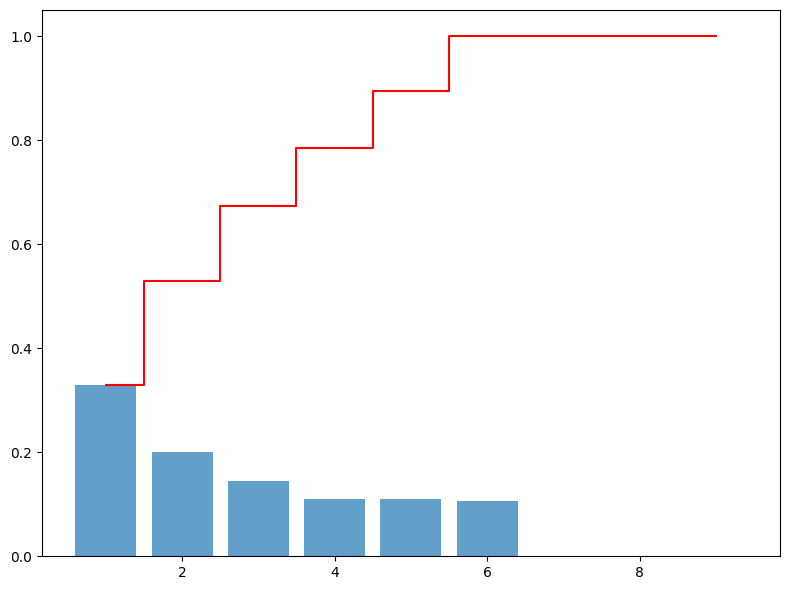

In [9]:
plt.figure(figsize=(8, 6))

plt.bar(range(1, len(explained_variance) + 1), explained_variance / np.sum(explained_variance), alpha=0.7)
plt.step(range(1, len(cum_variance) + 1), cum_variance, where='mid', color='red')

plt.tight_layout()
plt.show()

In [11]:
y_train_pred_pca = pca_model.predict(X_train)
y_test_pred_pca = pca_model.predict(X_test)
train_ba_pca = balanced_accuracy_score(y_train, y_train_pred_pca)
test_ba_pca = balanced_accuracy_score(y_test, y_test_pred_pca)
print(f'train ba: {train_ba_pca}')
print(f'test ba: {test_ba_pca}')

train ba: 0.9718976673260797
test ba: 0.9752102888709749


In [5]:
X_train_subset = X_train[:75]
y_train_subset = y_train[:75] #using a smaller subset for training as it was taking too long to run

In [6]:
kpca_model = KPCA(contamination=contamination_rate, random_state=42)
kpca_model.fit(X_train)

KPCA(alpha=1.0, coef0=1, contamination=np.float64(0.07332722273143905),
   copy_X=True, degree=3, eigen_solver='auto', gamma=None, kernel='rbf',
   kernel_params=None, max_iter=None, n_components=None, n_jobs=None,
   n_selected_components=None,
   random_state=RandomState(MT19937) at 0x1771BA82640,
   remove_zero_eig=False, sampling=False, subset_size=20, tol=0)

In [8]:
y_train_pred_kpca = kpca_model.predict(X_train)
y_test_pred_kpca = kpca_model.predict(X_test)
train_ba_kpca = balanced_accuracy_score(y_train, y_train_pred_kpca)
test_ba_kpca = balanced_accuracy_score(y_test, y_test_pred_kpca)
print(f'train ba: {train_ba_kpca}')
print(f'test ba: {test_ba_kpca}')

train ba: 0.6268010220903396
test ba: 0.747750929698352


Exercitiul 3

In [3]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

In [10]:
data = loadmat('shuttle.mat')
X = data['X']
y = data['y'].ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)  
X_test_normalized = scaler.transform(X_test)   

In [11]:
print(X_train_normalized.shape)

(24548, 9)


In [13]:
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = Sequential([
            Input(shape=(9,)),              
            Dense(8, activation='relu'),
            Dense(5, activation='relu'),
            Dense(3, activation='relu')     
        ])
        
        self.decoder = Sequential([
            Dense(5, activation='relu'),
            Dense(8, activation='relu'),
            Dense(9, activation='sigmoid')  
        ])
    
    def call(self, inputs):
        encoded = self.encoder(inputs)      
        decoded = self.decoder(encoded)     
        return decoded

In [14]:
autoencoder = Autoencoder()
autoencoder.compile(optimizer=Adam(), loss='mse')
history = autoencoder.fit(
    X_train_normalized, X_train_normalized,  
    epochs=100,
    batch_size=1024,
    validation_data=(X_test_normalized, X_test_normalized),
    verbose=1
)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0218 - val_loss: 0.0184
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0174 - val_loss: 0.0145
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0136 - val_loss: 0.0111
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0104 - val_loss: 0.0086
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0081 - val_loss: 0.0067
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - val_loss: 0.0053
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - val_loss: 0.0044
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

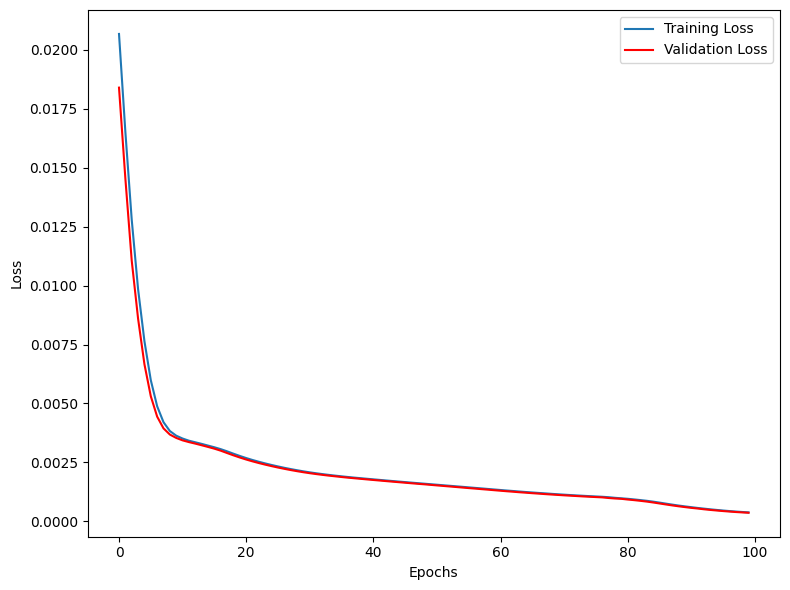

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
X_train_auto = autoencoder(X_train_normalized).numpy()
X_test_auto = autoencoder(X_test_normalized).numpy()
train_errors = np.mean((X_train_normalized - X_train_auto) ** 2, axis=1)
test_errors = np.mean((X_test_normalized - X_test_auto) ** 2, axis=1)

threshold = np.quantile(train_errors, 1 - contamination_rate) 

y_train_pred = (train_errors > threshold).astype(int)
y_test_pred = (test_errors > threshold).astype(int)

In [18]:
train_ba_auto = balanced_accuracy_score(y_train, y_train_pred)
test_ba_auto = balanced_accuracy_score(y_test, y_test_pred)
print(f'train ba: {train_ba_auto}')
print(f'test ba: {test_ba_auto}')

train ba: 0.7796744325899405
test ba: 0.772951239755632


Exercitiul 4

In [4]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, Conv2DTranspose

In [24]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train_normalized = X_train / 255.0
X_test_normalized = X_test / 255.0
noise_train = tf.random.normal(shape=X_train_normalized.shape) * 0.35
noise_test = tf.random.normal(shape=X_test_normalized.shape) * 0.35

X_train_noise = X_train_normalized + noise_train
X_test_noise = X_test_normalized + noise_test

X_train_noise = tf.clip_by_value(X_train_noise, 0.0, 1.0)
X_test_noise = tf.clip_by_value(X_test_noise, 0.0, 1.0)

In [25]:
X_train_normalized = tf.expand_dims(X_train_normalized, axis=-1)
X_test_normalized = tf.expand_dims(X_test_normalized, axis=-1)
X_train_noise = tf.expand_dims(X_train_noise, axis=-1)
X_test_noise = tf.expand_dims(X_test_noise, axis=-1)

In [26]:
class ConvAutoencoder(Model):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        self.encoder = Sequential([
            Input(shape=(28, 28, 1)),           
            Conv2D(filters=8, kernel_size=(3, 3), strides=2, padding='same', activation='relu'),
            Conv2D(filters=4, kernel_size=(3, 3), strides=2, padding='same', activation='relu')
        ])
        
        self.decoder = Sequential([
            Conv2DTranspose(filters=4, kernel_size=(3, 3), strides=2, padding='same', activation='relu'),
            Conv2DTranspose(filters=8, kernel_size=(3, 3), strides=2, padding='same', activation='relu'),
            Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='sigmoid')
        ])
    
    def call(self, inputs):
        encoded = self.encoder(inputs)      
        decoded = self.decoder(encoded)     
        return decoded

In [27]:
conv_autoencoder = ConvAutoencoder()
conv_autoencoder.compile(optimizer=Adam(), loss='mse')
history = conv_autoencoder.fit(
    X_train_normalized, X_train_normalized,  
    epochs=10,
    batch_size=64,
    validation_data=(X_test_normalized, X_test_normalized),
    verbose=1
)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0842 - val_loss: 0.0101
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0083 - val_loss: 0.0050
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0031 - val_loss: 0.0030


In [28]:
X_train_original_auto = conv_autoencoder(X_train_normalized).numpy()
train_errors = np.mean((X_train_normalized - X_train_original_auto) ** 2,  axis=(1, 2, 3))

threshold = np.mean(train_errors) + np.std(train_errors)

X_test_noise_auto = conv_autoencoder(X_test_noise).numpy()
X_test_original_auto = conv_autoencoder(X_test_normalized).numpy()

test_errors = np.mean((X_test_normalized - X_test_original_auto) ** 2, axis=(1, 2, 3))
test_errors_noise = np.mean((X_test_noise - X_test_noise_auto) ** 2, axis=(1, 2, 3))
y_test_original = (test_errors > threshold).astype(int)
y_test_noise = (test_errors_noise > threshold).astype(int)


In [29]:
original_acc = np.mean(y_test_original == 0)
print(original_acc)

0.8793


In [30]:
noisy_acc = np.mean(y_test_noise == 1)
print(noisy_acc)

1.0


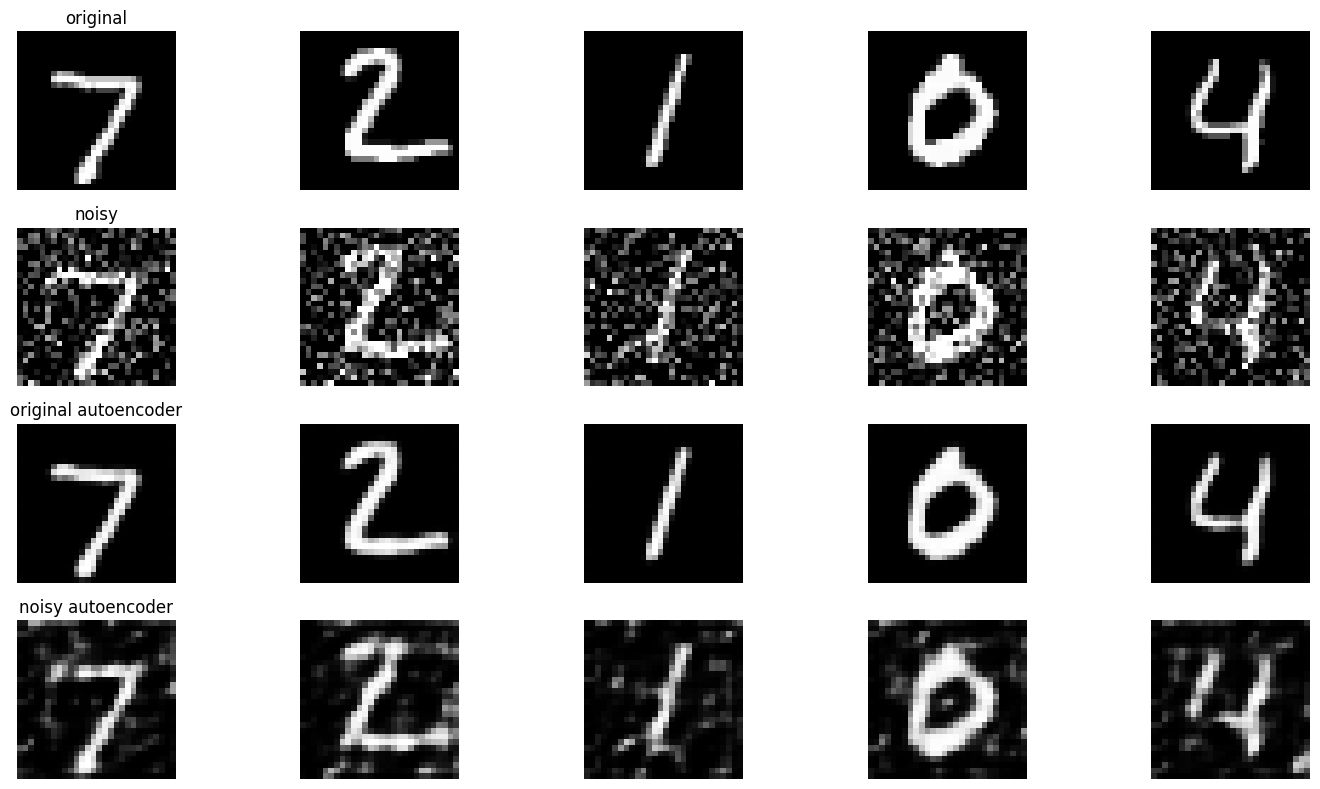

In [48]:
fig, axes = plt.subplots(4, 5, figsize=(15, 8))

for i in range(5):
    axes[0,i].imshow(X_test_normalized[i].numpy().reshape(28, 28), cmap='gray')
    axes[0,i].axis('off')
    
    axes[1,i].imshow(X_test_noise[i].numpy().reshape(28, 28), cmap='gray')
    axes[1,i].axis('off')

    axes[2,i].imshow(X_test_original_auto[i].reshape(28, 28), cmap='gray')
    axes[2,i].axis('off')

    axes[3,i].imshow(X_test_noise_auto[i].reshape(28, 28), cmap='gray')
    axes[3,i].axis('off')

axes[0,0].set_title('original')
axes[1,0].set_title('noisy')
axes[2,0].set_title('original autoencoder')
axes[3,0].set_title('noisy autoencoder')

plt.tight_layout()
plt.show()

In [42]:
denoise_autoencoder = ConvAutoencoder()
denoise_autoencoder.compile(optimizer=Adam(), loss='mse')
history = denoise_autoencoder.fit(
    X_train_noise, X_train_normalized,  
    epochs=10,
    batch_size=64,
    validation_data=(X_test_noise, X_test_normalized),
    verbose=1
)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.1055 - val_loss: 0.0124
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0118 - val_loss: 0.0104
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0105 - val_loss: 0.0099
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0101 - val_loss: 0.0097
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0097 - val_loss: 0.0093
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0095 - val_loss: 0.0092
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0093 - val_loss: 0.0091
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0092 - val_loss: 0.0090
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0091 - val_loss: 0.0088
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0090 - val_loss: 0.0088


In [43]:
X_test_noise_denoise_auto = denoise_autoencoder(X_test_noise).numpy()
X_test_original_denoise_auto = denoise_autoencoder(X_test_normalized).numpy()

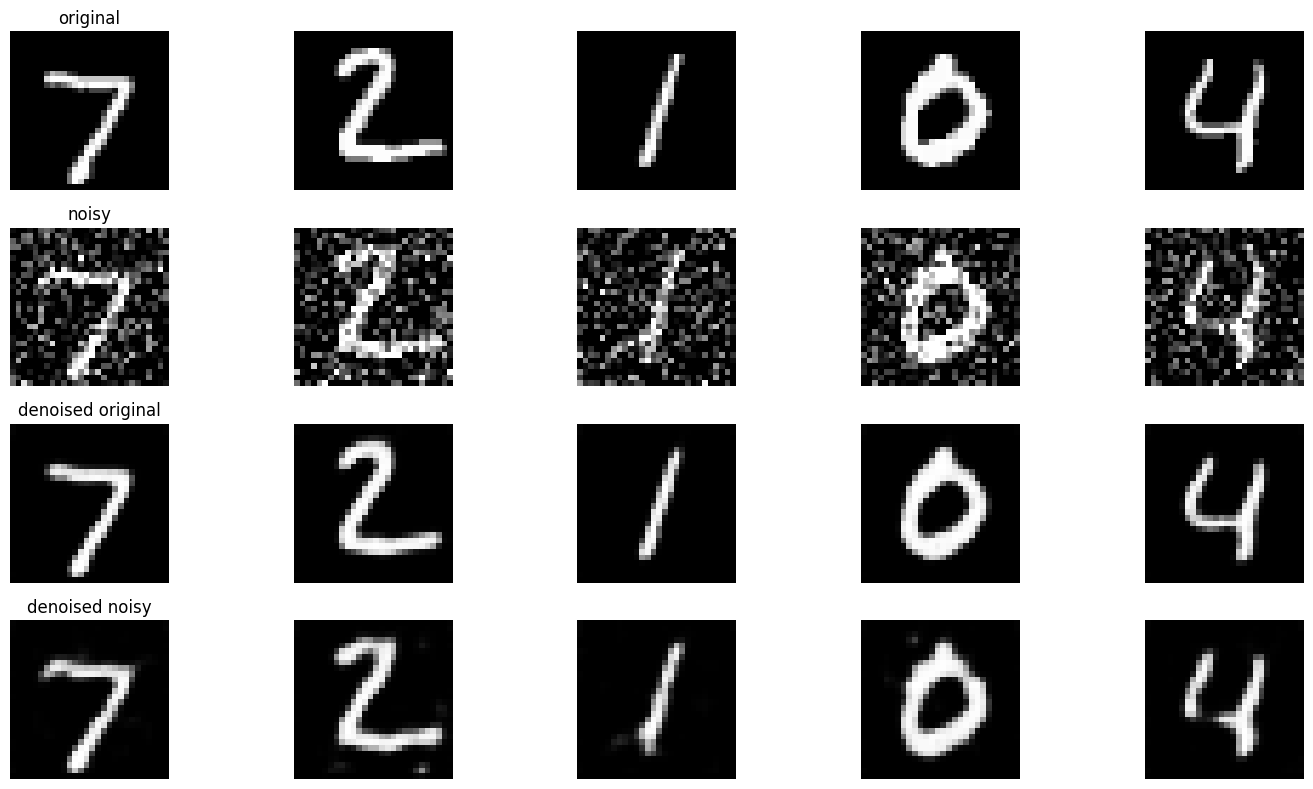

In [47]:
fig, axes = plt.subplots(4, 5, figsize=(15, 8))

for i in range(5):
    axes[0,i].imshow(X_test_normalized[i].numpy().reshape(28, 28), cmap='gray')
    axes[0,i].axis('off')
    
    axes[1,i].imshow(X_test_noise[i].numpy().reshape(28, 28), cmap='gray')
    axes[1,i].axis('off')

    axes[2,i].imshow(X_test_original_denoise_auto[i].reshape(28, 28), cmap='gray')
    axes[2,i].axis('off')

    axes[3,i].imshow(X_test_noise_denoise_auto[i].reshape(28, 28), cmap='gray')
    axes[3,i].axis('off')

axes[0,0].set_title('original')
axes[1,0].set_title('noisy')
axes[2,0].set_title('denoised original')
axes[3,0].set_title('denoised noisy')
plt.tight_layout()
plt.show()